# Data extraction

![texto alternativo](https://worldview.stratfor.com/sites/default/files/styles/article_full/public/cryptocurrency-gulf-display-shutterstock-1028639176.png?itok=K36RQG5A.jpg)

## Extracting (web scraping) daily data from top 200 cryptocurrencies available at  https://coinmarketcap.com/coins/ but also you can find more datasets with data by hour at https://www.cryptodatadownload.com/data/

Is important to run all libraries to solve possible issues first and avoid the environment restarting 

### Libraries

In [1]:
# ► First libs

import matplotlib.pyplot as plt
import plotly.express as px 
import pandas as pd
import numpy as np
import re

# ► More libs for the function

import datetime 
import csv

In [ ]:
# ► For PyCaret model (Regression models)

!pip install pycaret==2.0
#from pycaret.regression import *  # we will rin this line in next sections

     |████████████████████████████████| 256kB 4.1MB/s 
     |████████████████████████████████| 1.6MB 14.3MB/s 
     |████████████████████████████████| 266kB 31.3MB/s 
     |████████████████████████████████| 266kB 29.5MB/s 
     |████████████████████████████████| 6.8MB 28.1MB/s 
     |████████████████████████████████| 13.9MB 313kB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 1.8MB 43.4MB/s 
     |████████████████████████████████| 66.1MB 53kB/s 
     |████████████████████████████████| 102kB 10.7MB/s 
     |████████████████████████████████| 552kB 37.8MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 604kB 46.6MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 3.1MB 48.0MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 1.1MB 45.2MB/s 
     |████████████████████████████████| 81kB 9.9MB/s 
    

In [ ]:
# ► For prophet model (Time series)

import fbprophet
import matplotlib.pyplot as plt

In [ ]:
# ► For arima model (Time series)

!pip install pmdarima
from pmdarima.arima import auto_arima
from scipy import stats
from itertools import product
import warnings
import statsmodels.api as sm

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 2.1MB 16.8MB/s 
     |████████████████████████████████| 8.7MB 31.1MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


### Scraping first table

In [2]:
# ► Scraping main table wit pandas

url = 'https://coinmarketcap.com/coins/views/all/'
df = pd.read_html(url)[2]
df.head()

,Rank,Name,Symbol,Market Cap,Price,Circulating Supply,Volume (24h),% 1h,% 24h,% 7d,Unnamed: 10
0,1,Bitcoin,BTC,"$190,539,423,089","$10,305.82","18,488,518 BTC","$65,199,414,829",-0.37%,-1.23%,0.87%,NaN
1,2,Ethereum,ETH,"$40,437,880,301",$359.16,"112,591,495 ETH","$47,298,326,715",-1.61%,-6.53%,2.11%,NaN
2,3,XRP,XRP,"$10,831,909,455",$0.240649,"45,011,240,343 XRP *","$1,914,576,826",-0.44%,-2.41%,0.32%,NaN
3,4,Polkadot,DOT,"$4,387,316,309",$5.15,"852,647,705 DOT *","$1,194,222,621",2.29%,0.26%,7.30%,NaN
4,5,Binance Coin,BNB,"$4,288,134,942",$29.69,"144,406,560 BNB *","$1,605,353,917",-4.35%,5.33%,31.99%,NaN


In [3]:
# ► Getting rid of '$,' simbols

df.Price = df['Price'].apply(lambda x: float(re.sub('([$,]*)','',x)))
df.sort_values(by=['Price'], inplace=True, ascending=False)

In [4]:
# ► Below Bitcoin is omitted because its price is too high to appreciate the rest of the coins

fig = px.bar(df[1:], y='Price', x='Name', text='Name')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(template='seaborn', title='Coins available for scraping')
fig.show()

In [5]:
coins_available = list(df.Name)

In [6]:
# ► Repacing ' ' and '.' for '-' and deleting '[]#'  

coins_available = [re.sub('([\s+.])','-',coin.lower()).replace('[','').replace(']','').replace('#','') for coin in coins_available]

In [7]:
print(coins_available)

['bitcoin', 'ethereum', 'bitcoin-cash', 'bitcoin-sv', 'monero', 'unobtanium', 'dash', 'zcash', 'bonorum', 'litecoin', 'kusama', 'bitcoinpos', 'binance-coin', 'obyte', 'counos-x', 'neo', 'salus', 'decred', 'elrond', 'largo-coin', 'energy-web-token', 'newyork-exchange', 'bitcoin-gold', 'counos-coin', 'horizen', 'cosmos', 'polkadot', 'ethereum-classic', 'zcoin', 'chainx', 'arweave', 'bitcoinhd', 'mimblewimblecoin', 'solana', 'waves', 'celo', 'eos', 'vitae', 'qtum', 'tezos', 'zenon', 'platincoin', 'serum', 'elastos', 'ghostprism', 'haven-protocol', 'cryptonex', 'factom', 'energi', 'lisk', 'monacoin', 'zynecoin', 'helium', 'hypercash', 'blocknet', 'nano', 'ontology', 'tomochain', 'gxchain', 'loki', 'dero', 'bitcoin-diamond', 'bhpcoin', 'komodo', 'baer-chain', 'ouroboros', 'skycoin', 'theta', 'stratis', 'ergo', 'neblio', 'icon', 'darma-cash', 'bitcoin-2', 'fusion', 'aidos-kuneen', 'insolar', 'pivx', 'aeon', 'nebulas', 'ark', 'wanchain', 'xenioscoin', 'algorand', 'grin', 'monero-classic', 'be

## Function to obtain some data coins like 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap'.



In [8]:
# ► Function to extract data

def get_data(coins_available):
 
  # ► User types a number

  print(coins_available)
  coin_name = input('Type a valid coin name: ').lower()

  while True:

    if coin_name not in coins_available:
      print('Coin name should not contain spaces instead use "-" and type all in lowercase')
      coin_name = input('Type again a valid coin name: ').lower()
    else:
      break
  
  # ► Scrapping the coin name

  today = datetime.date.today()  # todays date
  mktcap_page = 'https://coinmarketcap.com/currencies/'+ coin_name +'/historical-data/?start=20130428&amp;end='+"{:%Y%m%d}".format(today)
  full_data = pd.read_html(mktcap_page)[2]
  full_data.rename(columns={'Open*': 'Open', 'Close**': 'Close'}, inplace=True)

  # ► This function replaces ',' for nothing and then changes data type from object to float

  def obj_to_num(df,cols):
      
      def obj_to_num(row):
          if ',' in str(row):
            row = row.replace(',','')
            return float(row)
          else:
            return float(row)

      for col in cols:     
          df[col] = df[col].apply(obj_to_num) 

      return df

  # ► This function changes data column type from object to timestamp[ns] and also can changes other columns to float 

  def prepare_data(file):
  
    columns = ['Open','High','Low','Close','Volume','Market Cap']
    file['Date'] = pd.to_datetime(file['Date'])
    num_data = obj_to_num(file,columns)

    return num_data

  return prepare_data(full_data)


## Coin exploration (Ethereum in this case)

You can type any coin (available in the list) to be analized

In [9]:
# ► Type the coin name you want

my_coin = get_data(coins_available)

['bitcoin', 'ethereum', 'bitcoin-cash', 'bitcoin-sv', 'monero', 'unobtanium', 'dash', 'zcash', 'bonorum', 'litecoin', 'kusama', 'bitcoinpos', 'binance-coin', 'obyte', 'counos-x', 'neo', 'salus', 'decred', 'elrond', 'largo-coin', 'energy-web-token', 'newyork-exchange', 'bitcoin-gold', 'counos-coin', 'horizen', 'cosmos', 'polkadot', 'ethereum-classic', 'zcoin', 'chainx', 'arweave', 'bitcoinhd', 'mimblewimblecoin', 'solana', 'waves', 'celo', 'eos', 'vitae', 'qtum', 'tezos', 'zenon', 'platincoin', 'serum', 'elastos', 'ghostprism', 'haven-protocol', 'cryptonex', 'factom', 'energi', 'lisk', 'monacoin', 'zynecoin', 'helium', 'hypercash', 'blocknet', 'nano', 'ontology', 'tomochain', 'gxchain', 'loki', 'dero', 'bitcoin-diamond', 'bhpcoin', 'komodo', 'baer-chain', 'ouroboros', 'skycoin', 'theta', 'stratis', 'ergo', 'neblio', 'icon', 'darma-cash', 'bitcoin-2', 'fusion', 'aidos-kuneen', 'insolar', 'pivx', 'aeon', 'nebulas', 'ark', 'wanchain', 'xenioscoin', 'algorand', 'grin', 'monero-classic', 'be

In [10]:
my_coin.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2020-09-13,387.52,388.96,354.34,365.57,1.500590e+10,4.116003e+10
1,2020-09-12,374.60,387.54,367.84,387.18,1.329541e+10,4.358820e+10
2,2020-09-11,368.12,376.63,355.58,374.70,2.729627e+10,4.217730e+10
3,2020-09-10,351.43,377.39,351.11,368.10,3.142113e+10,4.143005e+10
4,2020-09-09,337.82,359.16,332.16,351.11,1.454793e+10,3.951283e+10


In [11]:
my_coin.dtypes

Date          datetime64[ns]
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume               float64
Market Cap           float64
dtype: object

In [12]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=my_coin['Date'], y=my_coin['Open'],
                    mode='lines',
                    name='Open'))
fig.add_trace(go.Scatter(x=my_coin['Date'], y=my_coin['High'],
                    mode='lines',
                    name='High'))
fig.add_trace(go.Scatter(x=my_coin['Date'], y=my_coin['Low'],
                    mode='lines',
                    name='Low'))
fig.add_trace(go.Scatter(x=my_coin['Date'], y=my_coin['Close'],
                    mode='lines',
                    name='Close'))

#fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title="Coin behavior from its beginning, price in USD")

fig.show()

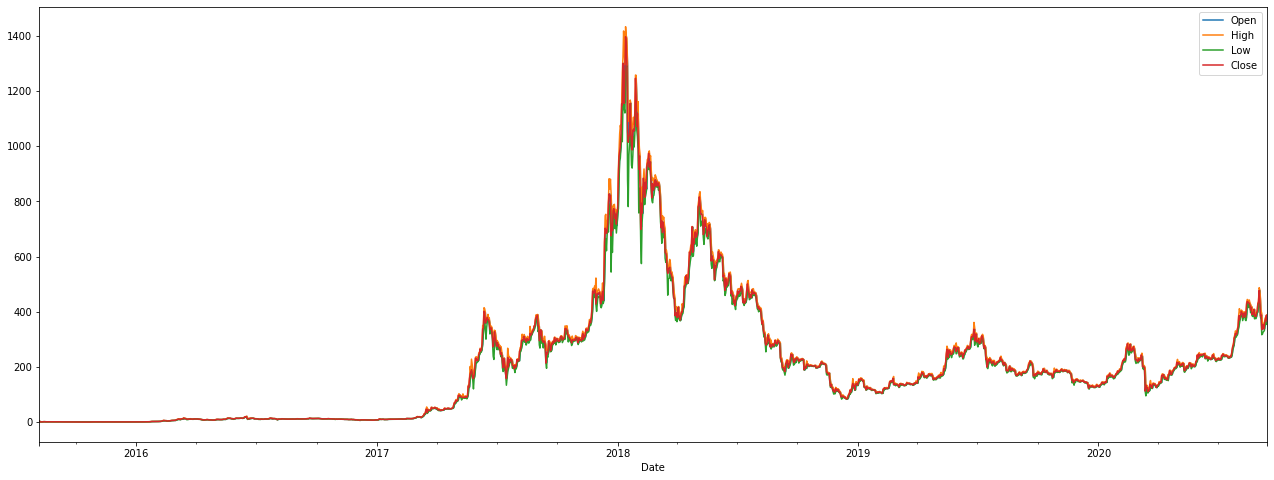

In [13]:
my_coin_graph = my_coin.set_index('Date') 
_ = my_coin_graph[['Open','High','Low','Close']].plot(figsize=(22, 8))

In [14]:
# ► Saving data to csv
my_coin.to_csv('my_coin_daily_data.csv')

# Models

### FbProphet

In [ ]:
# ► Prophet

'''import fbprophet
import matplotlib.pyplot as plt'''


In [ ]:
# ► Data after 2017-01-01

my_coin_high = my_coin[['High','Date']][my_coin.Date >= '2017-01-01']

In [ ]:
# ► Model won't see last 10 days to be compared

my_coin_high_p = my_coin_high[10:]

In [ ]:
# ► Renaming columns for Prophet

my_coin_high_p = my_coin_high_p.rename(columns = {'Date':'ds','High':'y'})

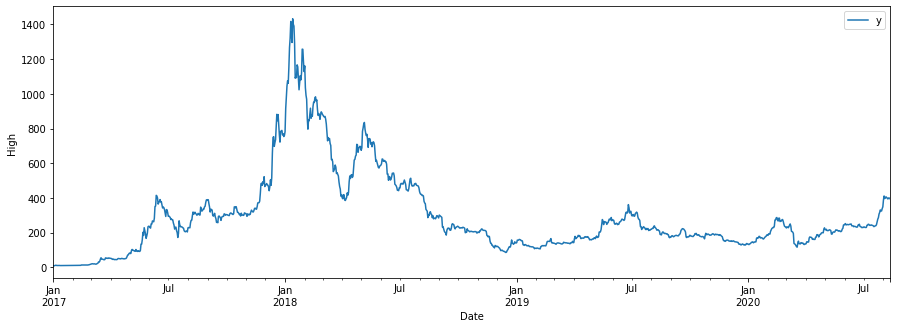

In [ ]:
# ► Plot

ax = my_coin_high_p.set_index('ds').plot(figsize=(15, 5))
ax.set_ylabel('High')
ax.set_xlabel('Date')

plt.show()

In [ ]:
# ► setting this hyperparameter to 0.8  https://facebook.github.io/prophet/docs/trend_changepoints.html#adjusting-trend-flexibility
# ► 1.1 = mse(2805.25), 0.8 = mse(2857.13), 1.2 = mse(3015.23), 0.75 = mse(3038.22), 0.9 = mse(3039.19), 0.5 = mse(3182.94)   

m = fbprophet.Prophet(changepoint_prior_scale=1.1)

In [ ]:
m.fit(my_coin_high_p)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=30)

In [ ]:
forecast_p = m.predict(future)

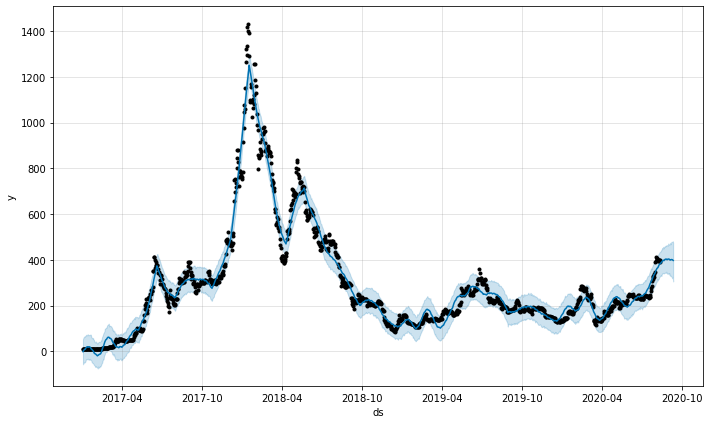

In [ ]:
m.plot(forecast_p);

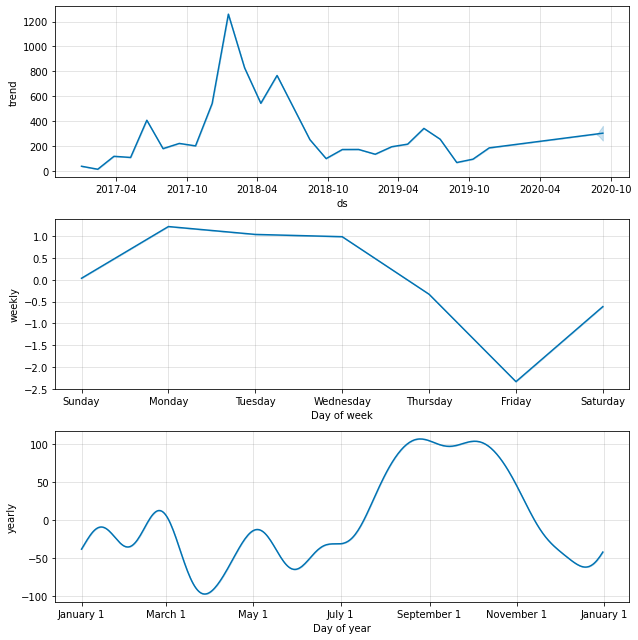

In [ ]:
m.plot_components(forecast_p);

In [ ]:
# ► predictions and real data

my_coin_inverse = my_coin_high.copy() 
my_coin_inverse.High = my_coin_inverse.High.values[::-1]                        # To change value orders from the original data
my_coin_forecast = pd.concat([forecast_p['ds'],my_coin_inverse['High'],forecast_p['yhat']], axis=1,keys=['date','high','prophet_high'])

In [ ]:
# ► The model didn't see this high values

my_coin_forecast[-30:-20]

,date,high,prophet_high
1320,2020-08-13,432.90,385.002730
1321,2020-08-14,444.58,385.302292
1322,2020-08-15,441.75,389.168145
1323,2020-08-16,436.27,391.803274
1324,2020-08-17,442.73,394.810959
1325,2020-08-18,432.58,396.287933
1326,2020-08-19,427.02,397.726687
1327,2020-08-20,418.73,397.730465
1328,2020-08-21,418.64,396.882797
1329,2020-08-22,396.47,399.592812


### Arima

In [ ]:
# ► Libraries
'''
!pip install pmdarima
from pmdarima.arima import auto_arima
from scipy import stats
from itertools import product
import warnings
import statsmodels.api as sm'''

'\n!pip install pmdarima\nfrom pmdarima.arima import auto_arima\nfrom scipy import stats\nfrom itertools import product\nimport warnings\nimport statsmodels.api as sm'

In [ ]:
# ► Create a copy with values in reverse

my_coin_high_a = (my_coin_high[10:].copy()).set_index('Date').iloc[::-1]


In [ ]:
my_coin_high_a.head()

,High
Date,
2017-01-01,8.47
2017-01-02,8.44
2017-01-03,10.00
2017-01-04,11.28
2017-01-05,11.89


In [ ]:
# Arima tunning hyperparameters
# Initial approximation of parameters

Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(my_coin_high_a.High, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12),enforce_stationarity=False,
                                            enforce_invertibility=False).fit(disp=-1)
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [ ]:
forecast_arima = pd.DataFrame(best_model.predict(start=0, end=len(my_coin_forecast)-1))

In [ ]:
forecast_arima = forecast_arima.rename(columns = {0:'arima_high'})

In [ ]:
forecast_arima

,arima_high
2017-01-01,0.000000
2017-01-02,9.673193
2017-01-03,9.377621
2017-01-04,10.708148
2017-01-05,12.067468
...,...
2020-09-07,394.235482
2020-09-08,393.889631
2020-09-09,392.220571
2020-09-10,391.868214


In [ ]:
# ► Joining data frames

my_coin_forecast_cp = pd.concat([my_coin_forecast.set_index('date'),forecast_arima], axis = 1, sort = False)

In [ ]:
# ► Comparing 10 unseen data by both models

my_coin_forecast_cp[-30:-20]

,high,prophet_high,arima_high
2020-08-13,432.90,385.002730,389.678566
2020-08-14,444.58,385.302292,388.074515
2020-08-15,441.75,389.168145,387.779858
2020-08-16,436.27,391.803274,385.715833
2020-08-17,442.73,394.810959,384.986199
2020-08-18,432.58,396.287933,386.918528
2020-08-19,427.02,397.726687,390.512720
2020-08-20,418.73,397.730465,390.291815
2020-08-21,418.64,396.882797,391.165455
2020-08-22,396.47,399.592812,389.847775


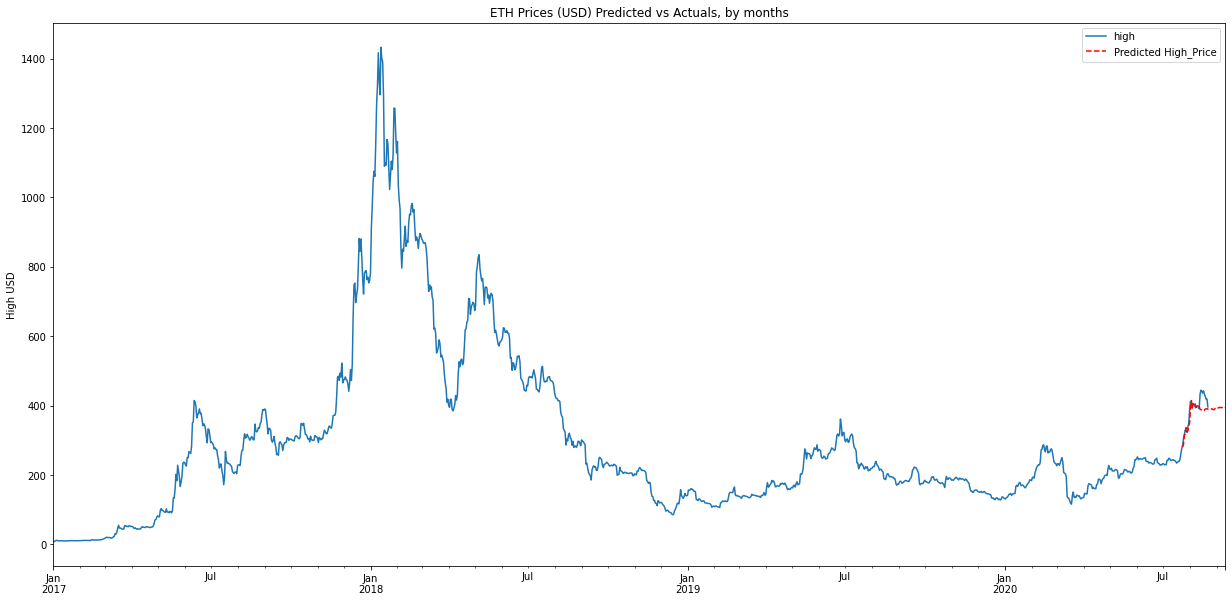

In [ ]:
plt.figure(figsize=(21,10))
my_coin_forecast_cp.high.plot()
my_coin_forecast_cp.arima_high[-50:].plot(color='r', ls='--', label='Predicted High_Price')
plt.legend()
plt.title('ETH Prices (USD) Predicted vs Actuals, by months')
plt.ylabel('High USD')
plt.show()

### PyCaret

In [ ]:
#!pip install pycaret==2.0

In [ ]:
# ► To use regression models

from pycaret.regression import *

In [ ]:
#import pandas as pd
#my_coin = pd.read_csv('my_coin_daily_data.csv')
#my_coin['Date'] = pd.to_datetime(my_coin['Date'])

In [ ]:
my_coin_high_py = my_coin_forecast_cp.reset_index()

In [ ]:
my_coin_high_py = my_coin_high_py[['index','high']][:-30]
my_coin_high_py.tail()

,index,high
1315,2020-08-08,393.99
1316,2020-08-09,399.74
1317,2020-08-10,399.38
1318,2020-08-11,398.48
1319,2020-08-12,391.31


In [ ]:
exp_reg = setup(data = my_coin_high_py, target = 'high')

 
Setup Succesfully Completed.


,Description,Value
0,session_id,1248
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(1320, 2)"
4,Missing Values,False
5,Numeric Features,0
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 0
INFO:logs:setup() succesfully completed......................................


In [ ]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Lasso Regression,172.1403,58885.1788,241.9901,-0.0002,0.9989,2.1843,0.0099
1,Elastic Net,170.7185,59213.3320,242.4907,-0.0011,0.9871,2.0233,0.0091
2,Bayesian Ridge,171.8065,59138.6018,242.4294,-0.0019,0.9939,2.1130,0.0145
3,TheilSen Regressor,166.4698,59445.3763,242.9620,-0.0057,0.9725,1.9443,2.1182
4,Ridge Regression,172.7497,59190.1274,242.6274,-0.0063,1.0025,2.2157,0.0093
5,Least Angle Regression,172.8520,59230.5890,242.7134,-0.0071,1.0029,2.2193,0.0136
6,Linear Regression,172.6177,59256.7298,242.7611,-0.0077,1.0024,2.1939,0.0086
7,Lasso Least Angle Regression,170.9855,59686.9665,243.4681,-0.0093,0.9887,2.0203,0.0095
8,Orthogonal Matching Pursuit,172.7301,59450.9975,243.1891,-0.0106,1.0020,2.1836,0.0097
9,Light Gradient Boosting Machine,179.0426,63266.3469,250.8957,-0.0765,1.0233,2.2827,0.0396


INFO:logs:create_model_container: 1
INFO:logs:master_model_container: 1
INFO:logs:display_container: 2
INFO:logs:Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=1248,
      selection='cyclic', tol=0.0001, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


In [ ]:
# ► Creating an ensemble meta-estimator that fits a base regressor on the whole dataset

blender_top3 = blend_models(compare_models(n_select = 3))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,177.0660,59103.1829,243.1115,0.0028,1.1386,2.9391
1,174.6410,63877.5324,252.7400,0.0242,0.9703,2.0183
2,172.8729,56818.5547,238.3664,-0.0132,1.0287,2.3689
3,165.2257,46256.3908,215.0730,-0.0550,1.1316,2.9601
4,171.7420,50199.2024,224.0518,-0.0498,0.9663,1.9106
5,168.8547,55443.9357,235.4654,0.0501,0.9202,1.7192
6,190.1007,81305.0449,285.1404,0.0217,0.9402,1.6437
7,176.6564,64985.7322,254.9230,-0.0243,1.0521,2.3881
8,174.2621,61040.8435,247.0645,0.0242,0.9554,1.6782
9,143.4579,49573.8812,222.6519,0.0471,0.8233,1.4399


INFO:logs:create_model_container: 5
INFO:logs:master_model_container: 5
INFO:logs:display_container: 7
INFO:logs:VotingRegressor(estimators=[('Lasso_0',
                             Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                                   max_iter=1000, normalize=False,
                                   positive=False, precompute=False,
                                   random_state=1248, selection='cyclic',
                                   tol=0.0001, warm_start=False)),
                            ('Elastic Net_1',
                             ElasticNet(alpha=1.0, copy_X=True,
                                        fit_intercept=True, l1_ratio=0.5,
                                        max_iter=1000, normalize=False,
                                        positive=False, precompute=False,
                                        random_state=1248, selection='cyclic',
                                        tol=0.0001, warm_start=False)),
          

In [ ]:
# ► It does not plot Hyperparams cause is blended model  

evaluate_model(blender_top3)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
# ► Stage of predictions

datat = pd.DataFrame(my_coin_forecast_cp.index).rename(columns={0: "index"})
lr_pred_new = predict_model(blender_top3, data = datat)

In [ ]:
my_coin_forecast_cp['pycaret_high'] = lr_pred_new['Label'].values

### LSTM (Long Short Term Memory)

"Trying to kill a fly with a gun"

It's a little bit complicated to understand the code below but it works, I've been looking for a LSTM with keras but most of them are used incorrectly

Some information to understand RNN's https://colah.github.io/posts/2015-08-Understanding-LSTMs/

https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru
Both Neural Networks are wrong

In [ ]:
# ► https://www.kaggle.com/johanvandenheuvel/lstm-model-of-stockdata

In [ ]:
# ► import mpl_finance interesting package

In [41]:
# ► libraries for LSTM

# Scale Data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler                
# Indicator
from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error
# Model Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense, GRU, LSTM, Dropout, Bidirectional
from keras.optimizers import SGD

In [16]:
# ► Loading Data and changing the order

df = pd.read_csv('my_coin_daily_data.csv', index_col='Date', parse_dates = ['Date'])
df = df[::-1]
df.head()

,Unnamed: 0,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,,
2015-08-07,1864,2.830000,3.540000,2.520000,2.770000,164329.0,166610555.0
2015-08-08,1863,2.790000,2.800000,0.714725,0.753325,674188.0,45486894.0
2015-08-09,1862,0.706136,0.879810,0.629191,0.701897,532170.0,42399573.0
2015-08-10,1861,0.713989,0.729854,0.636546,0.708448,405283.0,42818364.0
2015-08-11,1860,0.708087,1.130000,0.663235,1.070000,1463100.0,64569288.0


In [17]:
dflstm = df['High']

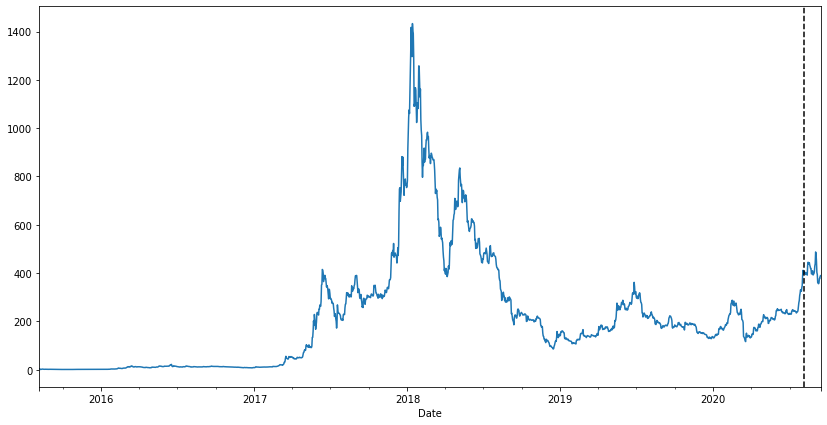

In [18]:
# Splitting data graph

ax = dflstm.plot(figsize=(14, 7))
ax.axvline(dflstm.index[-40], linestyle="--", c="black")

In [ ]:
'''scaler = StandardScaler()
train_arr = scaler.fit_transform(df_train)
# inverse tansform
def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})


def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df
'''

In [19]:
# Scaling all data

scaler = MinMaxScaler(feature_range=(-1,1))
sc_lstm = scaler.fit_transform(dflstm.reset_index().drop(['Date'], 1))

In [30]:
def split_data(stock, lookback):
    
    data_raw = stock
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = 40 
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [31]:
lookback = 21 # choose sequence length
LSTM_train_inputs, LSTM_train_outputs, LSTM_test_inputs, LSTM_test_outputs = split_data(sc_lstm, lookback)
print('x_train.shape = ',LSTM_train_inputs.shape)
print('y_train.shape = ',LSTM_train_outputs.shape)
print('x_test.shape = ',LSTM_test_inputs.shape)
print('y_test.shape = ',LSTM_test_outputs.shape)

x_train.shape =  (1804, 20, 1)
y_train.shape =  (1804, 1)
x_test.shape =  (40, 20, 1)
y_test.shape =  (40, 1)


In [32]:
# ► LSTM model structure

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [33]:
# initialise model architecture
nn_model = build_model(LSTM_train_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_train_inputs, LSTM_train_outputs, 
                            epochs=10, batch_size=1, shuffle=True)

Epoch 1/10
1804/1804 [==============================] - 9s 5ms/step - loss: 0.0677
Epoch 2/10
1804/1804 [==============================] - 9s 5ms/step - loss: 0.0490
Epoch 3/10
1804/1804 [==============================] - 9s 5ms/step - loss: 0.0450
Epoch 4/10
1804/1804 [==============================] - 9s 5ms/step - loss: 0.0385
Epoch 5/10
1804/1804 [==============================] - 10s 5ms/step - loss: 0.0379
Epoch 6/10
1804/1804 [==============================] - 10s 5ms/step - loss: 0.0346
Epoch 7/10
1804/1804 [==============================] - 9s 5ms/step - loss: 0.0327
Epoch 8/10
1804/1804 [==============================] - 9s 5ms/step - loss: 0.0299
Epoch 9/10
1804/1804 [==============================] - 9s 5ms/step - loss: 0.0290
Epoch 10/10
1804/1804 [==============================] - 9s 5ms/step - loss: 0.0279


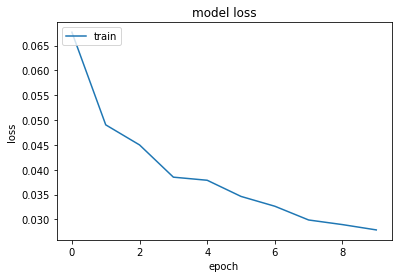

In [37]:
# "Loss"
plt.plot(nn_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

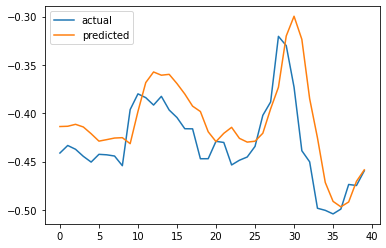

The Mean Absolute Error is: 0.027961215112784432


In [38]:
# Predicting by point, one step forward, this is something that we don't want and much people does.

plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
print('The Mean Absolute Error is: {}'.format(MAE))

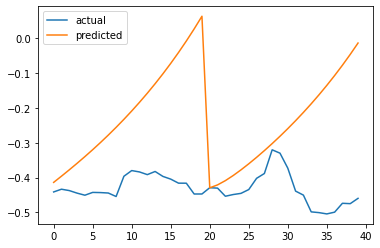

The Mean Absolute Error is: 0.2008669059099601


In [40]:
# https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo/blob/master/lstm.py
# ► Predicting two windows

def predict_sequence_full(model, data, window_size):

    '''Shift the window by 1 new prediction each time, re-run predictions on new window'''
    curr_frame = data[0]  
    predicted = []        
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

pred_win1 = predict_sequence_full(nn_model, LSTM_test_inputs[:20], 20)
pred_win2 = predict_sequence_full(nn_model, LSTM_test_inputs[-20:], 20)

plt.plot(LSTM_test_outputs, label="actual")
plt.plot(pred_win1 + pred_win2, label="predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, pred_win1 + pred_win2)
print('The Mean Absolute Error is: {}'.format(MAE))

### GRU (Gated Recurrent Units)

In [45]:
X_train = LSTM_train_inputs
y_train = LSTM_train_outputs

In [47]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train, y_train,epochs=10,batch_size=150)

Epoch 1/10
13/13 [==============================] - 1s 87ms/step - loss: 0.2162
Epoch 2/10
13/13 [==============================] - 1s 83ms/step - loss: 0.0921
Epoch 3/10
13/13 [==============================] - 1s 81ms/step - loss: 0.0427
Epoch 4/10
13/13 [==============================] - 1s 86ms/step - loss: 0.0184
Epoch 5/10
13/13 [==============================] - 1s 79ms/step - loss: 0.0117
Epoch 6/10
13/13 [==============================] - 1s 88ms/step - loss: 0.0105
Epoch 7/10
13/13 [==============================] - 1s 86ms/step - loss: 0.0094
Epoch 8/10
13/13 [==============================] - 1s 81ms/step - loss: 0.0094
Epoch 9/10
13/13 [==============================] - 1s 87ms/step - loss: 0.0087
Epoch 10/10
13/13 [==============================] - 1s 80ms/step - loss: 0.0084


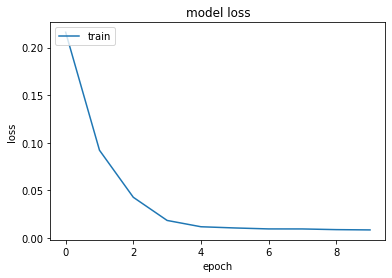

In [49]:
plt.plot(regressorGRU.history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

### Comparing

In [ ]:
my_coin_forecast_cp[-30:-20]

,high,prophet_high,arima_high,pycaret_high
2020-08-13,432.90,385.002730,389.678566,293.1198
2020-08-14,444.58,385.302292,388.074515,303.7527
2020-08-15,441.75,389.168145,387.779858,295.6777
2020-08-16,436.27,391.803274,385.715833,293.5974
2020-08-17,442.73,394.810959,384.986199,293.0792
2020-08-18,432.58,396.287933,386.918528,295.7888
2020-08-19,427.02,397.726687,390.512720,291.6421
2020-08-20,418.73,397.730465,390.291815,293.1198
2020-08-21,418.64,396.882797,391.165455,303.7527
2020-08-22,396.47,399.592812,389.847775,295.6777


In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=my_coin_forecast_cp.index[-40:], y=my_coin_forecast_cp['high'][-40:],
                    mode='lines',
                    name='Open'))
fig.add_trace(go.Scatter(x=my_coin_forecast_cp.index[-40:], y=my_coin_forecast_cp['prophet_high'][-40:],
                    mode='lines',
                    name='High'))
fig.add_trace(go.Scatter(x=my_coin_forecast_cp.index[-40:], y=my_coin_forecast_cp['arima_high'][-40:],
                    mode='lines',
                    name='Low'))
fig.add_trace(go.Scatter(x=my_coin_forecast_cp.index[-40:], y=my_coin_forecast_cp['pycaret_high'][-40:],
                    mode='lines',
                    name='Close'))

fig.update_layout(title="Coin behavior forecast vs actuals, price in USD")

fig.show()

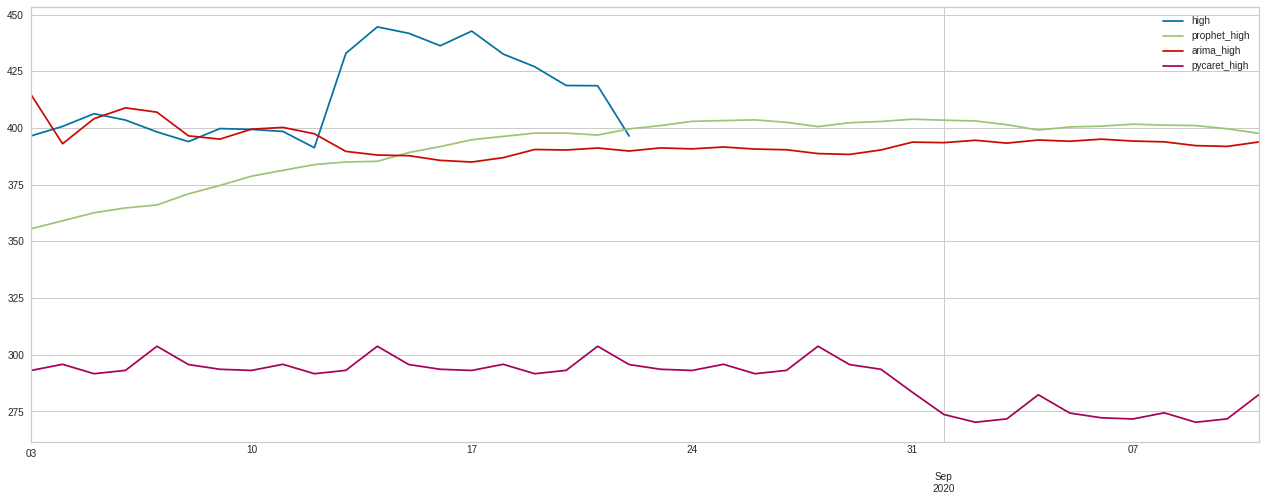

In [ ]:
_ = my_coin_forecast_cp[['high','prophet_high','arima_high','pycaret_high']][-40:].plot(figsize=(22, 8))

In [ ]:
# ► In the last step to compare models, not before cause there are issues with sklearn versions for pmdarima and pycaret 
from sklearn.metrics import mean_squared_error as mse
print('10 days mse arima: ',mse(my_coin_forecast_cp.high[-30:-20],my_coin_forecast_cp.arima_high[-30:-20]))
print('10 days mse prophet: ',mse(my_coin_forecast_cp.high[-30:-20],my_coin_forecast_cp.prophet_high[-30:-20]))
print('10 days mse pycaret: ',mse(my_coin_forecast_cp.high[-30:-20],my_coin_forecast_cp.pycaret_high[-30:-20]))

10 days mse arima:  1888.8995141742755
10 days mse prophet:  1594.5691387289044
10 days mse pycaret:  17963.389228648997


 
*   All models can be even tuned to get better-forecasted results.
*   The last 10 days are omitted to train models.
*   Still remains LSTM experimentation.

